# Exercise 4

In this exercise we will introduce a simple showcase for Galerkin methods in 1D, using polynomials as trial and test functions. Let us define the space of polynomials which fulfill the homogeneous Dirichlet boundary conditions:
$$
\begin{align*}
& V_n := \operatorname{span}\{v_1,\ldots,v_n\}, \quad\text{where} \\
& v_k(x) := (1-x^2)x^{k-1} \quad \text{for }k=1,\ldots,n, \quad \text{and} \\
& V := H^1([-1,1]).
\end{align*}
$$
We want to solve the boundary value problem


$$
    \left\{
	\begin{array}{l}
		-u''(x) = f(x) \qquad \text{for }x \in \Omega:=( -1, 1 ), \\
		u(-1) = u(1) = 0,
	\end{array}
    \right.
$$

using the Galerkin method with the specified trial and test space $V_n$.
For good practice, write down the weak formulation

$$
	\text{Find $u\in V$ such that $a(u,v)=F(v)$ for all $v\in V$}
$$

and the Galerkin equation, and verify that the chosen space $V_n$ fulfills the desired conditions.


### a)

First we need to compute the Galerkin matrix $A_n = [a(v_i,v_j)]_{ij}\in\mathbb{R}^{n \times n}$ and the vector $f_n=[F(v_i)]_i\in\mathbb{R}^n$.

To do so, write a function ```weak_laplace_poly``` that computes the matrix $A_n\in\mathbb{R}^{n \times n}$ given $n\in\mathbb{N}$ as input, and a function ```weak_rhs_poly``` that computes the vector $f_n\in\mathbb{R}^n$ given $n\in\mathbb{N}$ and $f:\Omega\to\mathbb{R}$ as input.

You can either implement the integrals analytically (when possible), or use Gauss-Legendre quadrature with $p=n+1$ points (see previous homework sheet).

You may use ```scipy.special.roots_legendre``` to compute the quadrature points and weights.
Then print $A_n$ for $n=4$ and compare it to the given solution:
$$
		A_4 \approx \begin{pmatrix}  
			2.667 & 0.000 & 0.533 & 0.000 \\
			0.000 & 1.600 & 0.000 & 0.686 \\
			0.533 & 0.000 & 0.838 & 0.000 \\
			0.000 & 0.686 & 0.000 & 0.584 
		\end{pmatrix}.
$$

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import roots_legendre


def weak_laplace_poly( n ):
    
    p = n + 1 # number of nodes of Gauss-Legendre quadrature
    nodes   = roots_legendre(p)[0]  # Gauss-Legendre nodes
    weights = roots_legendre(p)[1]  # Gauss-Legendre weights
    
    A = np.zeros([n,n])  # initialize the matrix A
    for i in range(n):
        for j in range(n):
            A[i,j] = sum( weights * ( derivative_v( nodes, i+1 )*derivative_v( nodes, j+1 )  ) )  # a(u,v)
            
    return A

def derivative_v( x, k ):   
    # analytic derivative of v_k(x)
    if k == 1:
        return - (k+1) * np.power( x, k )  # we can avoid 1/0 by doing this
    else:
        return (k-1) * np.power( x , k-2 ) - (k+1) * np.power( x, k )

def func_v( x, k ):
    return ( 1 - np.power(x,2) ) * np.power( x, k-1 ) 
    
def weak_rhs_poly( n , f , m = None ):
    
    p = n + 1 # number of nodes of Gauss-Legendre quadrature
    nodes   = roots_legendre(p)[0]  # Gauss-Legendre nodes
    weights = roots_legendre(p)[1]  # Gauss-Legendre weights
    
    F = [  sum( weights * ( f(nodes) * func_v( nodes, i+1 ) ) ) for i in range(n) ]
    
    return F


print( 
    np.array2string(
            weak_laplace_poly( 4),
            precision=3,
            floatmode='fixed',
            suppress_small=True,
    )
)


[[2.667 0.000 0.533 0.000]
 [0.000 1.600 0.000 0.686]
 [0.533 0.000 0.838 0.000]
 [0.000 0.686 0.000 0.584]]


### b)

Consider the instance of the BVP that has exact solution $u(x) = \sin( \pi x )$. Determine the function $f$, then compute the solution $u_n \in V_n$ of the proposed Galerkin equation. Create a plot comparing $u$ and $u_n$ for $n \in \{ 1,\ldots, 10\}$ in the same figure, using an equidistant grid with step size $h=\frac{1}{99}$.

Text(0, 0.5, 'u')

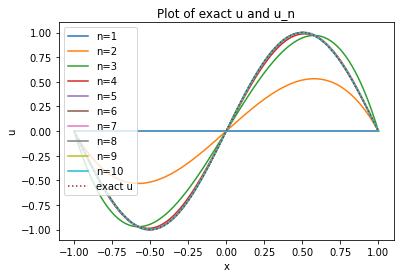

In [74]:
def u(x):
    return np.sin( np.pi * x )

def f(x):
    return np.power( np.pi, 2 ) * np.sin( np.pi * x )

x_g = np.linspace(-1,1,199)

for k in range(10):
    A = weak_laplace_poly( k+1 )
    F = weak_rhs_poly( k+1 , f )
    alpha = np.linalg.solve(A,F)   # Solve the system Aα= F
    u_n = [ sum( alpha * [ func_v( j , i+1 ) for i in range(k+1) ] )  for j in x_g ]  # Get the solution u_n = Σαφ
    plt.plot(x_g,u_n,label='n={}'.format(k+1))

plt.plot(x_g,u(x_g),label='exact u',c='brown',linestyle='dotted')

plt.legend()
plt.title('Plot of exact u and u_n')
plt.xlabel('x')
plt.ylabel('u')

### c)

Compute the $L^2$ error:
$$
	e_n := \left( \int_{-1}^{1} | u_n(x) - u(x) |^2 dx \right)^{\frac{1}{2}}
$$ for $n = 1, \dots, 10$, and plot $e_n$ against $n$ in a semilogy plot.

To compute the integral, use again Gauss-Legendre quadrature with $p=30$ points.

Text(0.5, 1.0, 'plot of error')

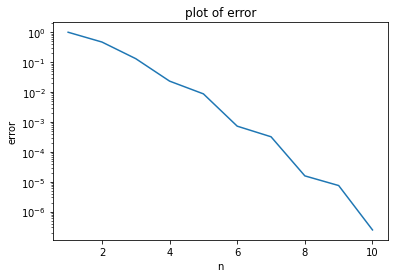

In [75]:
def e_h(n):
    
    nodes   = roots_legendre(30)[0]  # Gauss-Legendre nodes
    weights = roots_legendre(30)[1]  # Gauss-Legendre weights
    
    A = weak_laplace_poly( n )
    F = weak_rhs_poly( n , f )
    alpha = np.linalg.solve(A,F)   # Solve the system Aα= F
    u_n = [ sum( alpha * [ func_v( j , i+1 ) for i in range(n) ] )  for j in nodes ]  # Get the solution u_n = Σαφ
    u_e = u(nodes)  # Get the exact solution for each node
    error = np.sqrt( sum( np.power( u_n-u_e , 2 ) * weights ) )  # integral
    
    return error

k = np.arange(1,11,1)
error_list = [ e_h(i) for i in k ]
plt.semilogy(k,error_list)
plt.xlabel('n')
plt.ylabel('error')
plt.title('plot of error')